<a href="https://colab.research.google.com/github/rafaeljosem/MNA-ProyectoIntegrador_EQ10/blob/main/Avance-7/Avance7_Equipo10_PEFT_%26_Inst_Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

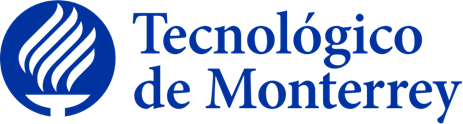

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Proyecto Integrador**

### Dra. Grettel Barceló Alonso
### Dr. Luis Eduardo Falcón Morales
### Mtra. Verónica Sandra Guzmán de Valle

## **Avance 7: Creación de nuevo conjunto de datos dividiéndolo en porciones y segunda iteración de entrenamiento del modelo (Parameter Efficient and Instruction Fine Tuning)**

### Domingo 9 de junio de 2024

## **Nombres y matrículas de los integrantes del Equipo 10:**

* Fernando Maytorena Espinosa de los Monteros | A01110946
* Jonathan Garza Bennet | A01793038
* Rafael José Mateo Comprés | A01793054

# 1. Loading, reviewing and formatting the dataset <a class="anchor" id="Loading, reviewing and formatting the dataset" ></a>

In order to improved performance compared to the first instruction fine tuning model developed, a two step process will be performed to increase the domain knowledge of our model. While evaluating the first model, the resposes were not performing as expected on the allucination metrics, giving us an indication of the possibility of additional training including the knowledge from all our dataset to be required. For the last, the two step process consists on:

1. Parameter Efficient Fine Tuning (PEFT) (Xu et al., 2023) including all our Mexican Federal Laws dataset divided in portions of maximum sequence length.

2. Instruction fine tuning using an expanded version of the dataset we previously generated.

In [ ]:
#Accelerate is required for using T4 GPUs. Session needs to be re-started after installation.
#!pip install accelerate
#!pip install bitsandbytes

In [ ]:
#Import/install required instances

import pandas as pd
#from sklearn.model_selection import train_test_split
!pip install datasets
from datasets import load_dataset, concatenate_datasets, Dataset
import re

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Code for loading a data set from a json file, not used when loading a HuggingFace dataset

#Instruction Fine Tuning URL
#url = 'https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/Avance-5/full_dataset.json'

#Load it into a Pandas Dataframe
#df_instruct = pd.read_json('https://raw.githubusercontent.com/rafaeljosem/MNA-ProyectoIntegrador_EQ10/main/Avance-5/full_dataset.json')

#Visualize Dataframe head
#df_instruct.head()

#Code for loading a data set from a csv file, not used when loading a HuggingFace dataset

#CSV location in mounted drive
data_path = '/content/drive/MyDrive/MNA/Proyecto Integrador/Data/MexicanLaws_PrePro_DataSetMexicanLaws_Clean_Compiled_PrePro_DataSet.csv'

#Read CSV into a Pandas dataframe using first column as index
df_mexican_federal_laws = pd.read_csv(data_path, index_col=0)

#Display dataframe head to visualize that data was loaded correctly
df_mexican_federal_laws.head()

,Available Text Files,Available Clean Text Files,Number of Empty Text Files Found,Number of Empty Clean Text Files Found,Number of Copied Text Files,File Name,Text,Tokens
CÓDIGO CIVIL FEDERAL,1,0,0,0,1,CÓDIGO CIVIL FEDERAL_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'civil', 'federal', 'código', 'civi..."
CÓDIGO DE COMERCIO,1,0,0,0,1,CÓDIGO DE COMERCIO_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'comercio', 'código', 'comercio', '..."
CÓDIGO DE JUSTICIA MILITAR,1,0,0,0,1,CÓDIGO DE JUSTICIA MILITAR_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'justicia', 'militar', 'código', 'j..."
CÓDIGO FEDERAL DE PROCEDIMIENTOS CIVILES,3,1,0,0,1,6.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'federal', 'procedimientos', 'civil..."
CÓDIGO FISCAL DE LA FEDERACIÓN,3,1,0,0,1,8_241218.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'fiscal', 'federación', 'código', '..."


In [ ]:
#Function that removes more that two subsequent line breaks
def clean_text(doc):
  #Empty list for tokens
  tokens = []

  #Remove all subsequent line breaks greater than 2
  clean_text = re.sub('\n{1,} | \n','\n', doc)
  clean_text = re.sub('\n{2,}','\n\n', clean_text)

  return clean_text

In [ ]:
#Remove all subsequent line breaks greater than 2 in all df documents
df_mexican_federal_laws['Clean Text'] = [clean_text(x) for x in df_mexican_federal_laws['Text']]

#Visualize df head to see if results are correct
df_mexican_federal_laws.head(30)

,Available Text Files,Available Clean Text Files,Number of Empty Text Files Found,Number of Empty Clean Text Files Found,Number of Copied Text Files,File Name,Text,Tokens,Clean Text
CÓDIGO CIVIL FEDERAL,1,0,0,0,1,CÓDIGO CIVIL FEDERAL_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'civil', 'federal', 'código', 'civi...",\n\nCódigo Civil Federal\n\nCÓDIGO CIVIL FEDER...
CÓDIGO DE COMERCIO,1,0,0,0,1,CÓDIGO DE COMERCIO_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'comercio', 'código', 'comercio', '...",\n\nCódigo de Comercio\n\nCÓDIGO DE COMERCIO\n...
CÓDIGO DE JUSTICIA MILITAR,1,0,0,0,1,CÓDIGO DE JUSTICIA MILITAR_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'justicia', 'militar', 'código', 'j...",\n\nCódigo de Justicia Militar\n\nCÓDIGO DE JU...
CÓDIGO FEDERAL DE PROCEDIMIENTOS CIVILES,3,1,0,0,1,6.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'federal', 'procedimientos', 'civil...",\n\nCódigo Federal de Procedimientos Civiles\n...
CÓDIGO FISCAL DE LA FEDERACIÓN,3,1,0,0,1,8_241218.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'fiscal', 'federación', 'código', '...",\n\nCódigo Fiscal de la Federación\n\nCÓDIGO F...
CÓDIGO MILITAR DE PROCEDIMIENTOS PENALES,3,1,0,0,1,CMPP_210618.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'militar', 'procedimientos', 'penal...",\n\nCódigo Militar de Procedimientos Penales\n...
CÓDIGO NACIONAL DE PROCEDIMIENTOS PENALES,3,1,0,0,1,CNPP_250618.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'nacional', 'procedimientos', 'pena...",\n\nCódigo Nacional de Procedimientos Penales\...
CÓDIGO PENAL FEDERAL,3,1,0,0,1,9_051118.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'penal', 'federal', 'código', 'pena...",\n\nCódigo Penal Federal\n\nCÓDIGO PENAL FEDER...
CONSTITUCIÓN POLÍTICA DE LOS ESTADOS UNIDOS MEXICANOS,3,1,2,1,1,CONSTITUCIÓN POLÍTICA DE LOS ESTADOS UNIDOS ...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['constitución', 'política', 'unidos', 'mexica...",\n\nConstitución Política de los Estados Unido...
DECRETO POR EL QUE SE ESTABLECE EL HORARIO ESTACIONAL QUE SE APLICARÁ EN LOS ESTADOS UNIDOS MEXICANOS,2,1,0,0,1,Dec_HEEUM_280417.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['decreto', 'establece', 'horario', 'estaciona...",\n\nDecreto por el que se establece el Horario...


In [ ]:
#len(df_instruct)

len(df_mexican_federal_laws)

230

In [ ]:
#Get AutoTokenizer from transformers
from transformers import AutoTokenizer

For the final model, Unsloth was chosen for model implementation and training. Unsloth allows 30 times faster training times, 60% less memory usage, allowing batches to be 6 times higher. It allows 0% loss in accuracy on it open source version. It supports most of the GPUs in the market like NVIDIA, Intel and AMD.
Manual autograd and chained matrix multiplication optimizations. The open source version of Unsloth allows finetuning to be 2 times faster with 50% less memory (Han, 2023).

Meta LLama 3 was chosen as the LLM to be fined due to its improvementes versus its predecessor model (Llama 2) on tasks related to reasoning, code generation, and instruction following which makes Llama 3 more controllable (Meta, 2024).

Llama 3 measured its performance with an evaluation set containing 1,800 questions covering 12 key use cases: asking for advice, brainstorming, classifying, answering closed questions, coding, creative writing, extraction, adopting a persona, answering open questions, reasoning, rewriting and summarizing (Meta, 2024). The last matches the objective of this project and our fine tuning data set structure, which supports even further Llama 3 to be the selected model.

Llama 3 8b is assumed to be robust enough to fulfill the project targets since only language tasks are going to be performed. Llama 3b requires singnificantly less resources to be trained and deployed than its 70b version.

In [ ]:
#Get the pretrained tokenizer model from unsloth Llama 3
tokenizer = AutoTokenizer.from_pretrained(
    "unsloth/llama-3-8b-bnb-4bit"
)

#instruction_tokens = tokenizer(INSTRUCTION, return_tensors="pt")["input_ids"].shape[1]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
#Code for loading a data set from a json file, not used when loading a HuggingFace dataset

#list_tokens_instruction = []
#list_tokens_output = []
#list_tokens_context = []
#list_total_tokens = []

#for index, row in df_instruct.iterrows():
    #print(row['c1'], row['c2'])

#    tokens_instruction = len(tokenizer(row['instruction'])["input_ids"])
#    tokens_output = len(tokenizer(row['output'])["input_ids"])
#    tokens_context = len(tokenizer(row['context'])["input_ids"])
#    total_tokens = tokens_instruction + tokens_output + tokens_context

#    list_tokens_instruction.append(tokens_instruction)
#    list_tokens_output.append(tokens_output)
#    list_tokens_context.append(tokens_context)
#    list_total_tokens.append(total_tokens)

In [ ]:
#Code for loading a data set from a csv file, not used when loading a HuggingFace dataset

list_tokens_index = []
list_tokens_text = []
list_total_tokens = []
list_total_unique_tokens = []
total_tokens_from_all_docs = 0

for index, row in df_mexican_federal_laws.iterrows():
    #print(row['c1'], row['c2'])

    tokens_index = len(tokenizer(index)["input_ids"])
    tokens_text = len(tokenizer(row['Text'])["input_ids"])
    total_unique_tokens = len(row['Tokens'])
    total_tokens = tokens_index + tokens_text

    total_tokens_from_all_docs = total_tokens_from_all_docs + total_tokens

    list_tokens_index.append(tokens_index)
    list_tokens_text.append(tokens_text)
    list_total_tokens.append(total_tokens)
    list_total_unique_tokens.append(total_unique_tokens)

In [ ]:
#Code for loading a data set from a json file, not used when loading a HuggingFace dataset

##Print longest set of instruction, outpup and dataset
#print('Longest total tokens instruction:\n\n'+ df_instruct['instruction'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')
#print('Longest total tokens output:\n\n'+ df_instruct['output'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')
#print('Longest total tokens context:\n\n'+ df_instruct['context'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')

In [ ]:
#Print total token analysis results from csv
print('Index maximum number of tokens: {}\n\n'.format(max(list_tokens_index)))
print('Text maximum number of tokens: {}\n\n'.format(max(list_tokens_text)))
print('Total maximum number of tokens: {}\n\n'.format(max(list_total_tokens)))
print('Total maximum number of unique tokens from all documents: {}\n\n'.format(max(list_total_unique_tokens)))
print('Total number of tokens from all documents: {}'.format(total_tokens_from_all_docs))

Index maximum number of tokens: 35


Text maximum number of tokens: 658401


Total maximum number of tokens: 658423


Total maximum number of unique tokens from all documents: 1528880


Total number of tokens from all documents: 10827812


In [ ]:
#Display the document with the maximum token count
df_mexican_federal_laws.iloc[list_total_tokens.index(max(list_total_tokens))].name

'LEY DE LOS IMPUESTOS GENERALES DE IMPORTACIÓN Y DE EXPORTACIÓN'

The following function takes the entire text per document, tokenizes it and divides it in even portions of maximum sequence length. The amount of portions will depend on the total number of tokens present per document. The function will adapt automatically for each document size, creating lists of variable length with decoded portions of text.

In [ ]:
#Function that divides raw text in portions of max_seq_length size
def get_text_portions(text, max_seq_length):

  length = max_seq_length-100

  #Tokenize text
  test_tokens = tokenizer(text)

  #Initialize empty list
  portioned_document_list = []

  #Get total available tokens
  total_test_tokens = len(test_tokens['input_ids'])

  #Calculate the number of portion
  portions = total_test_tokens / length

  #Always get an integer number that gives you portions equal or smaller in size than length
  if portions - round(portions) > 0:

    portions = round(portions) + 1

  elif portions - round(portions) < 0:

    portions = round(portions)

  #Loop for dividing the text in slices of length
  for i in range(portions):

    slice_start = i*length

    slice_end = (i+1)*length

    #Clip slice end to total_test_tokens
    if slice_end > total_test_tokens:

      slice_end = total_test_tokens

    #Slice tokens
    input_ids = test_tokens['input_ids'][slice_start:slice_end]

    #Decode and merge tokens
    portioned_document = ''.join(tokenizer.batch_decode(input_ids)[1:])

    #Append result in to list
    portioned_document_list.append(portioned_document)

  return portioned_document_list

Define maximum sequence length and divide all the corpus in portions to create a ne training dataset.

In [ ]:
#Divide in portions all the clean text

max_seq_length = 2048

df_mexican_federal_laws['Clean Portioned Text'] = [get_text_portions(x, max_seq_length) for x in df_mexican_federal_laws['Clean Text']]

In [ ]:
#Review header with new data including portions
df_mexican_federal_laws.head()

,Available Text Files,Available Clean Text Files,Number of Empty Text Files Found,Number of Empty Clean Text Files Found,Number of Copied Text Files,File Name,Text,Tokens,Clean Text,Clean Portioned Text
CÓDIGO CIVIL FEDERAL,1,0,0,0,1,CÓDIGO CIVIL FEDERAL_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'civil', 'federal', 'código', 'civi...",\n\nCódigo Civil Federal\n\nCÓDIGO CIVIL FEDER...,[\n\nCódigo Civil Federal\n\nCÓDIGO CIVIL FEDE...
CÓDIGO DE COMERCIO,1,0,0,0,1,CÓDIGO DE COMERCIO_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'comercio', 'código', 'comercio', '...",\n\nCódigo de Comercio\n\nCÓDIGO DE COMERCIO\n...,[\n\nCódigo de Comercio\n\nCÓDIGO DE COMERCIO\...
CÓDIGO DE JUSTICIA MILITAR,1,0,0,0,1,CÓDIGO DE JUSTICIA MILITAR_texto.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'justicia', 'militar', 'código', 'j...",\n\nCódigo de Justicia Militar\n\nCÓDIGO DE JU...,[\n\nCódigo de Justicia Militar\n\nCÓDIGO DE J...
CÓDIGO FEDERAL DE PROCEDIMIENTOS CIVILES,3,1,0,0,1,6.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'federal', 'procedimientos', 'civil...",\n\nCódigo Federal de Procedimientos Civiles\n...,[\n\nCódigo Federal de Procedimientos Civiles\...
CÓDIGO FISCAL DE LA FEDERACIÓN,3,1,0,0,1,8_241218.pdf.txtlimpio.txt,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,"['código', 'fiscal', 'federación', 'código', '...",\n\nCódigo Fiscal de la Federación\n\nCÓDIGO F...,[\n\nCódigo Fiscal de la Federación\n\nCÓDIGO ...


In [ ]:
#Initialize portions
total_portions = 0

#Count all portions of text achieved
for portions in df_mexican_federal_laws['Clean Portioned Text']:

  total_portions = total_portions + len(portions)

print('Total training portions from all dataset: {}'.format(total_portions))

Total training portions from all dataset: 5487


In [ ]:
#Visualize for reviewing results
df_mexican_federal_laws['Clean Portioned Text'][0][-1]

'ido el presente Decreto en la\nResidencia del Poder Ejecutivo Federal, en la Ciudad de México, Distrito Federal, a veintitrés de\ndiciembre de dos mil trece.- Enrique Peña Nieto.- Rúbrica.- El Secretario de Gobernación, Miguel Ángel\nOsorio Chong.- Rúbrica.\n\nDECRETO por el que se derogan los artículos 139, 140, 141, 142, 143, 144 y 145 del\nCódigo Civil Federal.\n\nPublicado en el Diario Oficial de la Federación el 24 de diciembre de 2013\n\nArtículo Único. Se derogan los artículos 139, 140, 141, 142, 143, 144 y 145 del Código Civil Federal,\n\npara quedar como sigue:\n\n……….\n\nTransitorio\n\nÚnico.- El presente Decreto entrará en vigor el día siguiente al de su publicación en el Diario Oficial\nde la Federación.\n\nMéxico, D.F., a 7 de noviembre de 2013.- Dip. Ricardo Anaya Cortes, Presidente.- Sen. Raúl\n\nCervantes Andrade, Presidente.- Dip. Javier Orozco Gomez, Secretario.- Sen. Iris Vianey Mendoza\nMendoza, Secretaria.- Rúbricas."\n\nEn cumplimiento de lo dispuesto por la frac

In [ ]:
#df_mexican_federal_laws.to_csv(data_path+'MexicanLaws_Clean_Compiled_Portioned_PrePro_DataSet.csv')

In [ ]:
#Code for loading a data set from a csv file, not used when loading a HuggingFace dataset

#Print longest set of instruction, outpup and dataset
print('Longest total tokens document:\n\n'+ df_mexican_federal_laws.iloc[list_total_tokens.index(max(list_total_tokens))].name + '\n\n')
#print('Longest total tokens output:\n\n'+ df_instruct['output'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')
#print('Longest total tokens context:\n\n'+ df_instruct['context'].iloc[list_total_tokens.index(max(list_total_tokens))] + '\n\n')

Longest total tokens document:

LEY DE LOS IMPUESTOS GENERALES DE IMPORTACIÓN Y DE EXPORTACIÓN




**A new approach was used to generate a new parameter efficient fine tuning data set using portions of text from all the mexican federal law documents, to cover all the content available in all the laws. The last is done to reduce the chances of allucination due to the lack of information from all the law documents. To divide each law in portions, first all the text was cleaned to remove any additional line breaks than optimal and then selected a value for max_seq_length, to divide the text in portions of maximum sequence lenght for each law document after tokenization and decoding back to text portions**

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

Unsloth supports Llama, Mistral, Phi-3, Gemma, Yi, DeepSeek, Qwen, TinyLlama, Vicuna, Open Hermes with 16bit LoRA or 4bit QLoRA. `max_seq_length` can be set to any value, since automatic RoPE Scaling via [kaiokendev's](https://kaiokendev.github.io/til) method.

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = max_seq_length # Could be any since RoPE Scaling is supported.
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We now add LoRA adapters so only 1 to 10% of all parameters are adapted.

**According to LoRA paper (Hu et al., 2021), a good generalization is achieved with r = 64 and alfa = 16. r is related to the number of parameters on the adapter layers, computational complexity and potential overfitting. Alfa is a weighting factor in between the base model and the fine tuning adaptations.**

In [ ]:
#Use Unsloth model
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Preparation

Dynamic prompt that adapts to variable number of portions per documents.

In [ ]:
#Define base prompt to concatenate the instruction, context and outputs to generate the fine tuning

#Base Alpaca dataset used as reference

#alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
#{}

### Input:
#{}

### Response:
#{}"""

#Adjusted prompt for Mexican Federal Laws Portioned Documents
mexican_portioned_federal_laws_prompt = """A continuación, se muestra el contenido de un documento que pertenece a las leyes federales mexicanas dividido en {} porciones de texto

### Documento: {}

### Porción de texto {}:
{}"""

#End Of String Token is required to avoid looping forever
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

#Function to format all instruction, context and outputs into fine tuning prompts
def formatting_mex_fed_portioned_laws_prompts_func(examples):

    #Using HF dataset

    #instructions = examples["instruction"]
    #inputs       = examples["input"]
    #inputs       = examples["context"]
    #outputs      = examples["output"]
    #texts = []
    #for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        #text = mexican_portioned_federal_laws_prompt.format(instruction, input, output) + EOS_TOKEN
        #texts.append(text)
    #return { "text" : texts, }

    #Using Pd dataframe

    #Empty list for text portions
    texts = []

    #Iterate among all elements and format them into the correct prompt format
    for index, row in examples.iterrows():
        #Must add EOS_TOKEN, otherwise your generation will go on forever!

        text_portions = len(row['Clean Portioned Text'])

        for text_portion in range(text_portions):

          text = mexican_portioned_federal_laws_prompt.format(text_portions,
                  index, text_portion+ 1, row['Clean Portioned Text'][text_portion]) + EOS_TOKEN

          texts.append(text)

    return { "text" : texts }

pass

#dataset = load_dataset("yahma/alpaca-cleaned", split = "train")

#Map dataset using alpaca base formatting
#dataset = dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
#Code for loading a data set from a csv file, not used when loading a HuggingFace dataset

#Testing formating prompt function to see output
formatting_mex_fed_portioned_laws_prompts_func(df_mexican_federal_laws.iloc[0:1])

{'text': ['A continuación, se muestra el contenido de un documento que pertenece a las leyes federales mexicanas dividido en 124 porciones de texto\n\n### Documento: CÓDIGO CIVIL FEDERAL\n\n### Porción de texto 1:\n\n\nCódigo Civil Federal\n\nCÓDIGO CIVIL FEDERAL\n\nNuevo Código publicado en el Diario Oficial de la Federación en cuatro partes\nlos días 26 de mayo, 14 de julio, 3 y 31 de agosto de 1928\n\nTEXTO VIGENTE\n\nÚltima reforma publicada DOF 09-03-2018\n\nEl C. Presidente Constitucional de la República se ha servido dirigirme el decreto que sigue:\n\nPLUTARCO ELIAS CALLES, Presidente Constitucional de los Estados Unidos Mexicanos, a sus\nhabitantes, sabed:\n\nQue en uso de la facultad que ha tenido a bien conferirme el H. Congreso de la Unión por Decretos de\n\n7 de enero y de 6 de diciembre de 1926 y de 3 de enero de 1928, expido el siguiente\n\nCÓDIGO CIVIL FEDERAL\n\nDisposiciones Preliminares\n\nArtículo 1o.- Las disposiciones de este Código regirán en toda la República en

In [ ]:
#Visualize first prompt based on the Alpaca dataset
#dataset["text"][0]

In [ ]:
#Create training and testing partitions with sklearn
#df_train, df_test = train_test_split(df_instruct, test_size=0.1, random_state=23, shuffle=True)

In [ ]:
#Split data set into training and test partition
#dataset_train_test = dataset.train_test_split(test_size=0.1)

In [ ]:
#Display partition sizes
#print('Traning partition size: {}\n\n'.format(dataset_train_test["train"].num_rows))
#print('Test partition size: {}'.format(dataset_train_test["test"].num_rows))

In [ ]:
#Creating training and test datasets with correct prompt formating

formatted_df_train = formatting_mex_fed_portioned_laws_prompts_func(df_mexican_federal_laws)
#formatted_df_test = formatting_prompts_func(df_test)

train_dataset = Dataset.from_dict({"text": [ct for ct in formatted_df_train['text']]})
#test_dataset = dataset.from_dict({"text": [ct for ct in formatted_df_test['text']]})

In [ ]:
#Visualize part of the train dataset
#dataset_train_test['train']['text'][0:3]

Sanity check to make sure maximum number of tokens is not higher than maximum sequence length

In [ ]:
#Visualize part of the train dataset
max_len_list = []

for element in train_dataset:

  len_tok = len(tokenizer(element['text'])['input_ids'])

  max_len_list.append(len_tok)

In [ ]:
print('The maximum number of tokens in the training data is: {}'.format(max(max_len_list)))

The maximum number of tokens in the training data is: 2031


In [ ]:
train_dataset[123]['text']

'A continuación, se muestra el contenido de un documento que pertenece a las leyes federales mexicanas dividido en 124 porciones de texto\n\n### Documento: CÓDIGO CIVIL FEDERAL\n\n### Porción de texto 124:\nido el presente Decreto en la\nResidencia del Poder Ejecutivo Federal, en la Ciudad de México, Distrito Federal, a veintitrés de\ndiciembre de dos mil trece.- Enrique Peña Nieto.- Rúbrica.- El Secretario de Gobernación, Miguel Ángel\nOsorio Chong.- Rúbrica.\n\nDECRETO por el que se derogan los artículos 139, 140, 141, 142, 143, 144 y 145 del\nCódigo Civil Federal.\n\nPublicado en el Diario Oficial de la Federación el 24 de diciembre de 2013\n\nArtículo Único. Se derogan los artículos 139, 140, 141, 142, 143, 144 y 145 del Código Civil Federal,\n\npara quedar como sigue:\n\n……….\n\nTransitorio\n\nÚnico.- El presente Decreto entrará en vigor el día siguiente al de su publicación en el Diario Oficial\nde la Federación.\n\nMéxico, D.F., a 7 de noviembre de 2013.- Dip. Ricardo Anaya Cor

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer` 60 steps is default, but `num_train_epochs=1` for a full run, and turn off `max_steps=None`. TRL's are also supported with `DPOTrainer`.

1 epoch is selected for this model training evaluation.

In [ ]:
#Import necessary instances
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

#Train the model with all the necessary inputs
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        num_train_epochs = 1,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
      ),
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was c

Map (num_proc=2):   0%|          | 0/5487 [00:00<?, ? examples/s]

In [ ]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.564 GB.
10.873 GB of memory reserved.


In [ ]:
#Create a copy of the base model for reference
model_base = model

In [ ]:
#Train the model
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 5,487 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 686
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,1.249700
2,1.211800
3,1.316000
4,1.331000
5,1.233700
6,1.394900
7,1.265200
8,1.302300
9,1.130600
10,1.145400


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

3692.0911 seconds used for training.
61.53 minutes used for training.
Peak reserved memory = 11.68 GB.
Peak reserved memory for training = 0.807 GB.
Peak reserved memory % of max memory = 29.522 %.
Peak reserved memory for training % of max memory = 2.04 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

Save the first training step to be able of evaluating it.

In [ ]:
#Local Save
model.save_pretrained("unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v2") # Local saving
tokenizer.save_pretrained("unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v2")

#HuggingFace Save
model.push_to_hub("JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v2", token = "") # Online saving
tokenizer.push_to_hub("JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v2", token ="") # Online saving

README.md:   0%|          | 0.00/580 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v2


Load the expanded intruction fine tuning data set from HuggingFace

In [ ]:
#Load Mexican Federal Laws instruction fine tuning dataset
dataset1 = load_dataset("a01110946/legal-mx-instruction-dataset-01", split = "train")
dataset2 = load_dataset("a01110946/legal-mx-instruction-dataset-02", split = "train")
dataset3 = load_dataset("a01110946/legal-mx-instruction-dataset-03", split = "train")

#Concatenate the two datasets

dataset = concatenate_datasets([dataset1, dataset2, dataset3])

Generating train split:   0%|          | 0/1752 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1744 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1760 [00:00<?, ? examples/s]

In [ ]:
#Get dataset size
dataset.num_rows

5256

In [ ]:
#Lists to save total number of tokens for all instruction, outputs and contexts
list_tokens_instruction = []
list_tokens_output = []
list_tokens_context = []
list_total_tokens = []

#Loop through dataset to count all tokens
for row in dataset:

    #print(row['instruction'])

    #Get all tokens from all rows

    #If None, total tokens is 0
    if row['instruction'] != None:
      tokens_instruction = len(tokenizer(row['instruction'])["input_ids"])
    else:
      tokens_instruction = 0

    if row['output'] != None:
      tokens_output = len(tokenizer(row['output'])["input_ids"])
    else:
      tokens_output = 0

    if row['context'] != None:
      tokens_context = len(tokenizer(row['context'])["input_ids"])
    else:
      tokens_output = 0
    #Sum all counts
    total_tokens = tokens_instruction + tokens_output + tokens_context

    #Append results to lists
    list_tokens_instruction.append(tokens_instruction)
    list_tokens_output.append(tokens_output)
    list_tokens_context.append(tokens_context)
    list_total_tokens.append(total_tokens)

In [ ]:
##Print longest set of instruction, outpup and dataset
print('Longest total tokens instruction:\n\n'+ dataset['instruction'][list_total_tokens.index(max(list_total_tokens))] + '\n\n')
print('Longest total tokens output:\n\n'+ dataset['output'][list_total_tokens.index(max(list_total_tokens))] + '\n\n')
print('Longest total tokens context:\n\n'+ dataset['context'][list_total_tokens.index(max(list_total_tokens))] + '\n\n')

Longest total tokens instruction:

Resume el contenido del Artículo 22 de la Ley Federal de Sanidad Animal.


Longest total tokens output:

El Artículo 22 de la Ley Federal de Sanidad Animal establece diferentes puntos de verificación e inspección zoosanitaria, como los sitios ubicados en territorio nacional autorizados por la Secretaría, los puntos de verificación e inspección zoosanitaria para importación, los puntos de verificación e inspección internos y los puntos de verificación e inspección sanitaria federal. También define términos como rastreabilidad, residuo tóxico, recinto fiscalizado estratégico, retención, riesgo zoosanitario, sanidad animal, entre otros.


Longest total tokens context:

Ley Federal de Sanidad Animal - Artículo 22. Verificación e inspección zoosanitaria: Sitio ubicado en territorio nacional autorizado por la Secretaría para constatar el cumplimiento de esta Ley y demás disposiciones de sanidad animal; Punto de verificación e inspección zoosanitaria para im

In [ ]:
#Print total token analysis results
print('Instructions maximum number of tokens: {}\n\n'.format(max(list_tokens_instruction)))
print('Output maximum number of tokens: {}\n\n'.format(max(list_tokens_output)))
print('Context maximum number of tokens: {}\n\n'.format(max(list_tokens_context)))
print('Total maximum number of tokens: {}'.format(max(list_total_tokens)))

Instructions maximum number of tokens: 122


Output maximum number of tokens: 628


Context maximum number of tokens: 1852


Total maximum number of tokens: 2002


Instruction fine tuning prompt formatting function

In [ ]:
#Define base prompt to concatenate the instruction, context and outputs to generate the fine tuning

#Base Alpaca dataset used as reference

#alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
#{}

### Input:
#{}

### Response:
#{}"""

#Base prompt
alpaca_based_prompt = """A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud

### Instrucción:
{}

### Entrada:
{}

### Respuesta:
{}"""

#End Of String Token is required to avoid looping forever
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

#Function to format all instruction, context and outputs into fine tuning prompts
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    #inputs       = examples["input"]
    inputs       = examples["context"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_based_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

    #Iterate among all elements and format them into the correct prompt format
    #for index, row in examples.iterrows():
       # Must add EOS_TOKEN, otherwise your generation will go on forever!
    #    text = alpaca_based_prompt.format(row["instruction"], row["context"], row["output"]) + EOS_TOKEN
    #    texts.append(text)
    #return { "text" : texts }

pass

#dataset = load_dataset("yahma/alpaca-cleaned", split = "train")

#Map dataset using alpaca base formatting
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/5256 [00:00<?, ? examples/s]

In [ ]:
#Visualize first prompt based on the Alpaca dataset
dataset["text"][0]

'A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud\n\n### Instrucción:\n¿Cuál es la libertad del testador al disponer de sus bienes según el Artículo 1344 del Código Civil Federal?\n\n### Entrada:\nCódigo Civil Federal - Artículo 1344. El testador es libre para establecer condiciones al disponer de sus bienes.\n\n### Respuesta:\nSegún el Artículo 1344 del Código Civil Federal, el testador es libre para establecer condiciones al disponer de sus bienes.<|end_of_text|>'

**Data is divided in train and test partitions. Test is 10% of the entire dataset**

In [ ]:
#Split data set into training and test partition
dataset_train_test = dataset.train_test_split(test_size=0.1)

In [ ]:
#Display partition sizes
print('Traning partition size: {}\n\n'.format(dataset_train_test["train"].num_rows))
print('Test partition size: {}'.format(dataset_train_test["test"].num_rows))

Traning partition size: 4730


Test partition size: 526


In [ ]:
dataset_train_test["train"][0]['text']

"A continuación se muestra una instrucción que describe una tarea, junto con una entrada que proporciona más contexto. Escribe una respuesta que complete adecuadamente la solicitud\n\n### Instrucción:\nSi un beneficiario del PROCAMPO desea utilizar sus pagos futuros como garantía crediticia, ¿qué debe tener en cuenta según la Ley de Capitalización del PROCAMPO?\n\n### Entrada:\nLey De Capitalización Del Procampo - Artículo 1. Se emite la presente Ley de Capitalización del PROCAMPO, en el marco de los artículos 25, 27 fracción XX y demás dispositivos correspondientes de la Constitución Política de los Estados Unidos Mexicanos, la Ley de Desarrollo Rural Sustentable, y otras disposiciones aplicables. La presente ley es de aplicación general y regirá en todo el territorio de los Estados Unidos Mexicanos; sus disposiciones son de orden público e interés general. Tiene por objeto establecer las disposiciones para el acceso anticipado y la utilización como garantía crediticia, de los pagos f

In [ ]:
#Create a copy of the peft model for reference
model_peft = model

We again employ `UnslothTrainer` and do instruction finetuning.

In [ ]:
#Import necessary instances
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

#Train the model with all the necessary inputs
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train_test["train"],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 8,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        num_train_epochs = 1,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        #max_steps = 60,
        # Select a 2 to 10x smaller learning rate for the embedding matrices!
        learning_rate = 5e-5,
        #embedding_learning_rate = 1e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
      ),
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1965: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `dataset_num_proc` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:307: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was c

Map (num_proc=8):   0%|          | 0/4730 [00:00<?, ? examples/s]

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 4,730 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 591
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,1.485700
2,1.403300
3,1.405300
4,1.252200
5,1.280700
6,1.191300
7,1.052100
8,1.050300
9,1.125500
10,0.789700


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1245.2607 seconds used for training.
20.75 minutes used for training.
Peak reserved memory = 11.68 GB.
Peak reserved memory for training = 0.807 GB.
Peak reserved memory % of max memory = 29.522 %.
Peak reserved memory for training % of max memory = 2.04 %.


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
#Local Save
model.save_pretrained("unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v3") # Local saving
tokenizer.save_pretrained("unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v3")

#HuggingFace Save

model.push_to_hub("JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v3", token = "")
tokenizer.push_to_hub("JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v3", token = "") # Online saving

README.md:   0%|          | 0.00/580 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/671M [00:00<?, ?B/s]

Saved model to https://huggingface.co/JonathanGarza/unsloth-llama-3-8b-bnb-4bit-Mexican-Federal-Laws-Instruct-FineTuned-v3


<a name="Data"></a>
### Conclusions

*This new approach results in training our model taking into consideration the whole context of our dataset and not only specific instructions paired with specific outputs. The first training process results in moderate reduction in the log loss function, while the second step further refines the model to be able of answering specific requests.*

*Model evaluation will be part of a separate notebook which will use the models adjusted with this training sequences for estimating their performance*

*Further revisions are still being considered to improve the model performance in case it remains not optimal*

*After reviewing Meta Llama 3 documentation, we found a disclaimer about only around 5% of the Llama 3 pre-training data set was made up of high-quality non-English language data spanning more than 30 languages. Good performance in other languages is expected, but not on the same level as with English.*

*The impact on performance on this project due to the last remains unknow and to be determined.*

*Other hyperparameters remain to be tested in case desired performance is not achieved, including increasing from 4bit to 16-bit LoRA if current resources allow it.*

*Taking the last into consideration and depending on the evaluation results, further possible improvement opportunities include:*

1. *Using a 16-bit model instead of 8-bit.*
2. *Increasing the context window to be 8192 tokens*
3. *Using Mistral 7B with with the same training cases we have used for Llama 3 taking advantage of the fact that it was trained in several languages including spanish and is capabilty of handling 32k tokens for context window.*


*Models were successfuly loaded to HuggingFace so they are available for further testing or training for the next project deliverables.*

<a name="Data"></a>
### References

Han, D. (2023, December 1). Introducing Unsloth. Unsloth. https://unsloth.ai/introducing

Kaiokendev. (2023, June 22). Things I’m learning while training superhot. kaiokendev.github.io. https://kaiokendev.github.io/til

Hu, E. J., Shen, Y., Wallis, P., Allen-Zhu, Z., Li, Y., Wang, S., Wang, L., & Chen, W. (2021, October 16). Lora: Low-rank adaptation of large language models. arXiv.org. https://arxiv.org/abs/2106.09685

Martinez-Seis, B., Pichardo-Lagunas, O., Koff, H., Equihua, M., Perez-Maqueo, O., & Hernández-Huerta, A. (2022, July 6). Unified, labeled, and semi-structured database of pre-processed Mexican laws. MDPI. https://www.mdpi.com/2306-5729/7/7/91

Mistral AI. (2024). Models: Mistral AI large language models. Mistral AI Large Language. https://docs.mistral.ai/getting-started/models/

Nodematic Labs. (2024, April 22). Llama-3-finetune-unsloth/count-tokens.py at main · nodematiclabs/llama-3-finetune-unsloth. GitHub. https://github.com/nodematiclabs/llama-3-finetune-unsloth/blob/main/count-tokens.py

Xu, L., Xie, H., Qin, S.-Z. J., Tao, X., & Wang, F. L. (2023, December 19). Parameter-efficient fine-tuning methods for pretrained language models: A Critical Review and assessment. arXiv.org. https://arxiv.org/abs/2312.12148